# Optimal Decision Tree Pruning Using School Test Data
In this article we will gain a better understanding of decision trees in a classification task by applying the technique to a dataset on school test scores. Our goal is to predict whether or not a particular student passed the test. We will quickly see that building an unrestricted tree usually leads to overfitting the data. Inputing limitations pertaining the way the tree is built can reduce overfitting, but these limitations have their own issues. A better way to avoid overfitting is to apply so called "cost efficiency pruning". The idea of cost efficiency pruning is to built a tree that achieves a tradeoff between maximizing the fit to the training data and minimizing the tree size. The relative importance of training data fit and tree size is governed by a paramater $ \alpha $. The optimal $ \alpha $ can then be found via k-fold cross validation and the tree corresponding to it is the optimal cost efficiency pruned tree.

## Data Modification
First, let us start by quickly exploring the dataset and make some convenient amendments to it, so that we can use the data for classification.

In [8]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('/Users/gabrielvollert/Downloads/test_scores.csv')
df.head(2)

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133 entries, 0 to 2132
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school           2133 non-null   object 
 1   school_setting   2133 non-null   object 
 2   school_type      2133 non-null   object 
 3   classroom        2133 non-null   object 
 4   teaching_method  2133 non-null   object 
 5   n_student        2133 non-null   float64
 6   student_id       2133 non-null   object 
 7   gender           2133 non-null   object 
 8   lunch            2133 non-null   object 
 9   pretest          2133 non-null   float64
 10  posttest         2133 non-null   float64
dtypes: float64(3), object(8)
memory usage: 183.4+ KB


In [10]:
# Describe object type variables
df.describe(include = 'object')

,school,school_setting,school_type,classroom,teaching_method,student_id,gender,lunch
count,2133,2133,2133,2133,2133,2133,2133,2133
unique,23,3,2,97,2,2133,2,2
top,GOOBU,Urban,Public,18K,Standard,1M9UM,Male,Does not qualify
freq,158,906,1582,31,1373,1,1077,1215


We have a total of 8 categorical variables. We are going to use one hot encoding to convert these categorical variables into dummys. Note that 3 of the 8 categorical variables have a relatively large number of categories. In order to keep the number of dummy variables low, we drop these 3 variables from the dataset. 

In [11]:
df = df.drop(['school','classroom','student_id'],axis=1)

In [12]:
# Describe float64 type variables
df.describe()

,n_student,pretest,posttest
count,2133.000000,2133.000000,2133.000000
mean,22.796531,54.955931,67.102203
std,4.228893,13.563101,13.986789
min,14.000000,22.000000,32.000000
25%,20.000000,44.000000,56.000000
50%,22.000000,56.000000,68.000000
75%,27.000000,65.000000,77.000000
max,31.000000,93.000000,100.000000


The target variable posttest is a numerical variable. In order to turn this problem into a binary classification, let us say a student passed the posttest if she achieved more than 65 points on the posttest. 

In [13]:
Passed= pd.cut(df['posttest'],bins=[0,65,100],labels=['failed','passed'])
df.insert(loc=8,column='Passed',value= Passed)
df.head(2)

,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest,Passed
0,Urban,Non-public,Standard,20.0,Female,Does not qualify,62.0,72.0,passed
1,Urban,Non-public,Standard,20.0,Female,Does not qualify,66.0,79.0,passed


As a final data preparation step, let us one hot encode the data and split it into a test and training data.

In [14]:
# Split Data in input and target variables
X = df.drop(['posttest','Passed'], axis = 1)
y = df['Passed']

# One hot encode categorical input variables
X_onehot = pd.get_dummies(X,drop_first=True)

# Split data into training and testing data using a 70/30 split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_onehot,y,random_state=44,train_size=0.7)

## Unrestricted Decision Tree
We now build and evaluate the decision tree without imposing any prior restrictions.

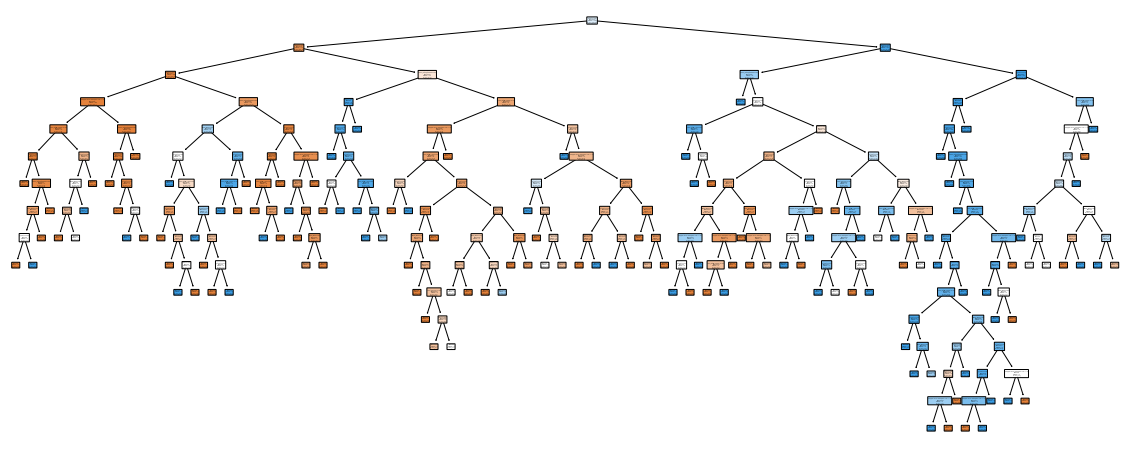

In [15]:
from sklearn.tree import DecisionTreeClassifier

# Build decision tree
dt = DecisionTreeClassifier()
dt = dt.fit(x_train,y_train)

# Plot decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20,8))
plot_tree(dt, feature_names=X_onehot.columns[0:], class_names=dt.classes_, filled=True, rounded=True);

The decision tree is huge. Let us check how well it performs on the testing data. 

In [16]:
pred = dt.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,pred,digits=4))

              precision    recall  f1-score   support

      failed     0.9161    0.9381    0.9270       291
      passed     0.9474    0.9284    0.9378       349

    accuracy                         0.9328       640
   macro avg     0.9317    0.9333    0.9324       640
weighted avg     0.9332    0.9328    0.9329       640



The accuracy is 93.28% which at first might seem high, but keep in mind we have the variable "pretest" in our data set which is probably a rather strong predictor of the "posttest" score, so we are generally looking to obtain high accuracies.

Since the decision tree is so large we suspect that it overfits the training data. Below we check whether this is the case.

In [17]:
# Calculating predictions for training data to check for overfitting
pred_train = dt.predict(x_train)

print(classification_report(y_train,pred_train,digits=4))

              precision    recall  f1-score   support

      failed     0.9740    0.9956    0.9846       676
      passed     0.9963    0.9780    0.9870       817

    accuracy                         0.9859      1493
   macro avg     0.9851    0.9868    0.9858      1493
weighted avg     0.9862    0.9859    0.9859      1493



A 98.6% accuracy on the training data is a good indicator that this tree is probably overfitting the data.

## Restricted Tree
We are now going to attempt to solve the overfitting issue by simply restricting the way in which the tree is allowed to grow.
### Maximum Depth Restriction
One easy way to prevent the tree from growing large is to set its maximum depth to a desired value. In this example we restrict the tree to only be able to grow to a maximal depth of 3. 

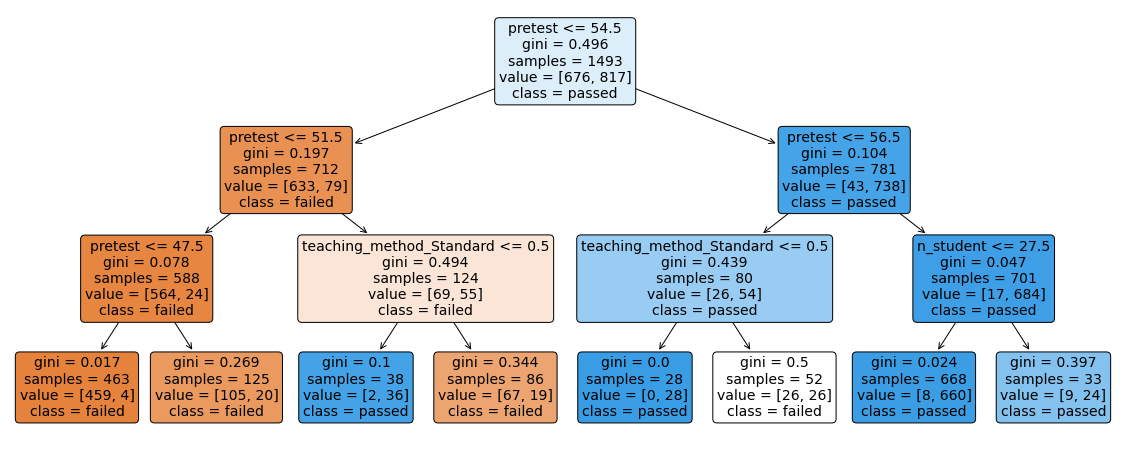

In [19]:
# Building tree with max_depth=3
dt_depth_3 = DecisionTreeClassifier(max_depth=3)
dt_depth_3 = dt_depth_3.fit(x_train,y_train)

# Plotting tree with max_depth=3
plt.figure(figsize=(20,8))
plot_tree(dt_depth_3,feature_names=X_onehot.columns[0:],  
                     class_names=dt.classes_,filled=True, rounded=True,fontsize=14);

In [20]:
# Checking whether max_depth=3 tree results in higher accuracy compared to original tree
pred_depth_3 = dt_depth_3.predict(x_test)
print(classification_report(y_test,pred_depth_3,digits=4))

              precision    recall  f1-score   support

      failed     0.9156    0.9691    0.9416       291
      passed     0.9729    0.9255    0.9486       349

    accuracy                         0.9453       640
   macro avg     0.9442    0.9473    0.9451       640
weighted avg     0.9468    0.9453    0.9454       640



The max_depth restricted tree achieves a higher accuracy (94.53% instead of 93.28%) compared to the original tree, since it does not suffer from overfitting the data as much as the original tree does. However, restricting a tree by limiting its max_depth is a rather crude way of avoiding overfitting, since this limitation is completely unrelated to the data itself. 

### Minimum Impurity Decrease Restriction
A more sophisticated way to limit the tree size is to require a minimal impurity decrease for each split of the tree. If the impurity decrease caused by a hypothetical split was less than the minmal required impurity decrease, such a split would not be performed.  

#### Node Impurity Definition
The node impurity describes how certain we could be that an observation belongs to a specific class if we had to make this decision at that exact node. A high node impurity corresponds to a high uncertainty. 

Per default, Scikit-Learn uses the Gini impurity to calculate the impurity of each node. The Gini impurity at node $i$ is calculated as: $$ G_i = 1- \sum_{k=1}^{n} p_{i,k} ^2, $$ where $p_{i,k}$ is the fraction of observations that belong to class $k$ versus the total observations at the node $i$. If all observations at node $i$ belong to a unique klass $k=l$, we have $p_{i,l} =1$ and therefore $G_i = 0$. If all observations at node $i$ are evenly distributed over the $k$ classes, we have $p_{i,m} = p_{i,l} = \frac{1}{n}  \quad \forall m,l \in K$, where $K$ is the set of classes of the target variable. Therefore, $$ G_i = 1- \sum_{k=1}^{n} p_{i,k} ^2 = 1 - n  {\left(\frac{1}{n}\right)}^2 = 1 - \frac{1}{n}.$$ Note that the maximum possible Gini impurity at each node is an increasing function of the number of classes in the target variable. This is important for the interpretation of the Gini node impurity: For binary classification tasks as in our case, a Gini impurity of 0.496 like we have it in the root node of our decision tree is very close to the maximal possible Gini impurity of 0.5. This means that the classes at the root node are very balanced i.e. we cannot be sure whether a student passed or not a priori. In contrast, if our target value had ten different categories (here: ten different possible marks), a Gini node impurity of 0.496 would indicate that some classes are over- \ under-representated to some extent (here: some marks were achieved significantly more often than others).

A decision tree makes its splits in such a way, that each split decreases the node impurity as much as possible. By making many of such efficient splits, a tree achieves a low node impurity eventually, enabling confident predictions regarding the class of the target variable. 
Let us return to our max_depth=3 decision tree from before and calculate some of the node impurity reductions caused by its splits. Thereby we will understand how important each split actually is for the tree's ability to correctly predict the target variable.

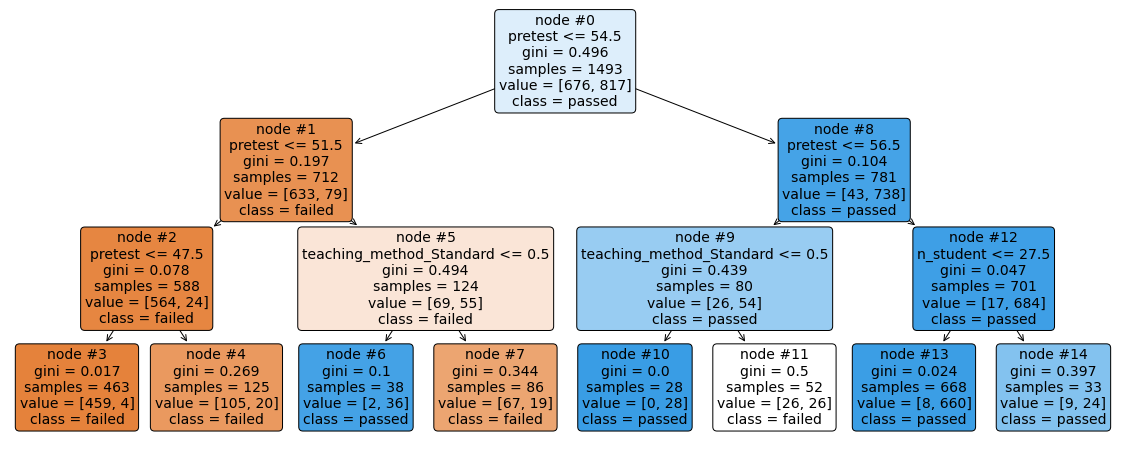

In [22]:
# Plot max_depth=3 tree again and number nodes
plt.figure(figsize=(20,8))
plot_tree(dt_depth_3,feature_names=X_onehot.columns[0:],  
                     class_names=dt.classes_,filled=True, rounded=True,fontsize=14,node_ids=True);

Let us consider the split at node 12. Before the tree splits this node, the Gini impurity is 0.047 and 701 observations lie in this node. The Gini impurity reduction caused by the split is simply the Gini impurity at node 12 minus the weighted average of the Gini impurities of the "new" nodes 13 and 14 (everything weighted by how many samples node 12 has relative to the whole sample):  $$ G_{12,reduction} = \frac{N_{12}}{N} \times \left[G_{12} - \left(\frac{N_{13}}{N_{12}} G_{13}+  \frac{N_{14}}{N_{12}} G_{14}\right)\right] =  \frac{701}{1493} \times \left[0.047 - \left(\frac{668}{701} 0.024 +  \frac{33}{701} 0.397\right)\right] = 0.00255 = 0.255\% $$
Similarly, we can calculate the value of the split at node 5:
$$ G_{5,reduction} = \frac{N_{5}}{N} \times \left[G_{5} - \left(\frac{N_{6}}{N_{5}} G_{6}+  \frac{N_{7}}{N_{5}} G_{7}\right)\right] =  \frac{124}{1493} \times \left[0.494 - \left(\frac{38}{124} 0.1 +  \frac{86}{124} 0.344\right)\right] = 0.01867 = 1.867\% $$

Now that we know about node impurity, we can understand why it might be suboptimal to limit a tree by simply limiting its max_depth. For our tree, being able to split at node 5 is a lot more important than being able to split at node 12 based on the different impurity reductions. Perhaps, the split at node 12 could be omitted in favour of another split, which achieves a higher impurity reduction than $G_{12,reduction} =  0.255\% $. This would result in a new tree with the same number of terminal nodes but a lower total node impurity. The new tree would have the same size and a better fit to the training data.  

It is actually possible to build such a tree. The only thing we have to change is instead of setting the max_depth we have to set the min_impurity_decrease. This will now grow a possibly assymetric tree, which stops once the impurity decrease achieved by the next split would be below the chosen threshold. In our case, I chose a threshold of $ 0.3\%$, which is smaller than $G_{5,reduction}$ and greater than $G_{12,reduction}$. Hence, our new tree will still split at node 5, but not at node 12 anymore.

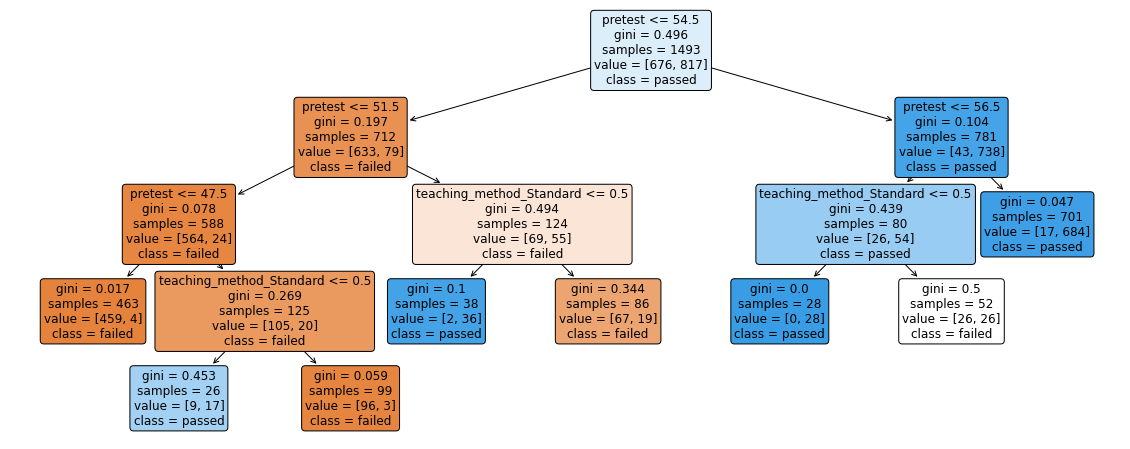

In [23]:
# Build tree with a min_impurity_reduction of 0.3%
dt_min_imp = DecisionTreeClassifier(min_impurity_decrease=0.003)
dt_min_imp = dt_min_imp.fit(x_train,y_train)

# Plot min_impurity_reduction tree
plt.figure(figsize=(20,8))
plot_tree(dt_min_imp,feature_names=X_onehot.columns[0:],  
                     class_names=dt.classes_,filled=True, rounded=True,fontsize=12);

Indeed, the split at node 12 disappeared. Also, node 2 is no longer being split. You can check for yourself, that the Gini impurity reduction caused by the split at node 2 was smaller than $0.3\%$. As mentioned, it would have been possible that we would see new splits emerging and have the tree depth be greater than 3, however this time it is not the case. Let us check how the min_impurity_decrease restricted tree performs on the test data. 

In [24]:
pred_min_imp = dt_min_imp.predict(x_test)
print(classification_report(y_test,pred_min_imp,digits=4))

              precision    recall  f1-score   support

      failed     0.9333    0.9622    0.9475       291
      passed     0.9676    0.9427    0.9550       349

    accuracy                         0.9516       640
   macro avg     0.9505    0.9524    0.9513       640
weighted avg     0.9520    0.9516    0.9516       640



We can see that the accuracy for the min_impurity_reduction limited tree improved slightly compared to the max_depth limited tree (95.16% compared to 94.53%).

However, there is still an issue with limiting the min_impurity_decrease: The tree is built via a greedy algorithm, which means that each particular split of the tree is made in order to achieve the maximum possible impurity reduction at the point of the split. The algorithm does not take into account how the choice of the current split affects the effectiveness of future splits farer down the tree. Thus, it is possible that a split with a low impurity reduction would be followed by a split with a high impurity reduction farer down the tree. If we only build the tree further if a given split exceeds the threshold for the minimal impurity reduction that we have set, we might end a tree to soon and "overlook" the possibility of a highly impurity reducing split further down the tree. 

## Cost Efficiency Pruning
So far we have seen how to build a tree and explored two of various ways to control the tree size before the tree is actually built in order to avoid overfitting. We have also seen why these ways to control the tree prior to its building are suboptimal. How can we obtain a non-overfitting tree in a better way? The answer is called "cost-complexity-pruning". The general idea is that we first build the whole original tree without restrictions and then select the subtree that achieves the best tradeoff between tree size and its ability to fit the training data. Formally, we pick the subtree that minimizes $$ R(T) \times \alpha |T|,$$ 
for a given $\alpha$. $R(T)$ is the total impurity of the terminal nodes weighted by their sample size in tree $T$. $|T|$ is the number of terminal nodes in the tree and thus measures the size of the tree. $\alpha$ is the parameter that governs the respective importance between minimizing the impurity and keeping the tree size low. [<sup>1</sup>](#fn1) The optimal $\alpha$ can then be found via cross-validation. The subtree corresponding to that $\alpha$ is the tree which we are then going to use to make predicitions for the test data. Now let us implement cost complexity pruning in Python. 

<span id="fn1"> For $\alpha = 0$, we retain the original unrestricted tree. </span>

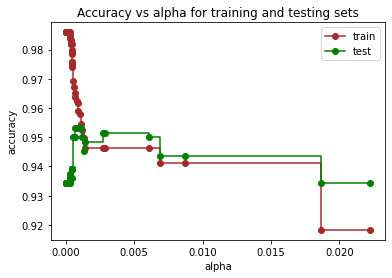

In [25]:
# Getting the alphas
path = dt.cost_complexity_pruning_path(x_train,y_train)

# Since the highest alpha will correspond to a tree without a split, we will cut this alpha from the analysis
ccp_alphas = path.ccp_alphas[:-1]

# Create one decision tree for each alpha
dt_alphas=[]
for x in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=44,ccp_alpha=x)
    dt.fit(x_train,y_train)
    dt_alphas.append(dt)

# Calculate accuracy for each alpha on the training data
train_scores = [clf.score(x_train, y_train) for clf in dt_alphas]
# Calculate accuracy for each alpha on the testing data
test_scores = [clf.score(x_test, y_test) for clf in dt_alphas]

#Plot train vs test accuracy for all alphas
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post",color='brown')
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post",color='green')
ax.legend()

As expected, the training accuracy goes down when $\alpha$ increases, because a higher $\alpha$ results in a smaller tree which fits the training data less well. 
Regarding the testing accuracy, we can see that for $\alpha=0$ or only slightly above $0$, the testing accuracy is relatively low, since the tree is overfitting the training data. Once $\alpha$ increases, the tesing accuracy also increases at first due to decreased overfitting. If $\alpha$ becomes too high, the testing accuracy drops again, as the tree has become to small and is now underfitting the training data. The optimal $\alpha$ is thus somewhere in the middle and we will now estimate the optimal $\alpha$ via k-fold cross validation. I chose $k=10$.

<AxesSubplot:xlabel='alpha', ylabel='accuracy'>

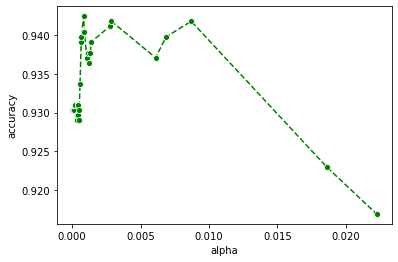

In [26]:
# Using 10-fold cross validation to get the accuracy over many different datasets

from sklearn.model_selection import cross_val_score

# Calculate 10-fold cross validation accuracy for each alpha
alpha_loop_vals=[]
for x in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=44,ccp_alpha=x)
    scores = cross_val_score(dt,x_train,y_train,cv=10)
    alpha_loop_vals.append([x,np.mean(scores)])
    
# Store cv-accuracies as df
alpha_results=pd.DataFrame(alpha_loop_vals,columns=['alpha','accuracy'])

# Plot cv-accuracies
sns.lineplot(data=alpha_results,x='alpha',y='accuracy',ls='--',marker='o',color='green')

We can see how fast the accuracy drops for higher $\alpha$, since the trees become to simple to fit the data well. From the graph, we can guess that the optimal $\alpha$ must be very low. Let us find it.

In [27]:
# Find alpha which maximizes accuracy (= "optimal alpha")
alpha_results.sort_values(by='accuracy',ascending=False).head()

,alpha,accuracy
39,0.000834,0.942403
48,0.002864,0.941763
51,0.008700,0.941758
47,0.002740,0.941092
40,0.000893,0.940403


In [28]:
# Store optimal alpha as number
alpha_optimal = alpha_results.at[39,'alpha']

Now we only need to build the tree and we are done with cost complexity pruning. Since the optimal $\alpha$ is so small in our case, we expect the corresponding tree to be big.

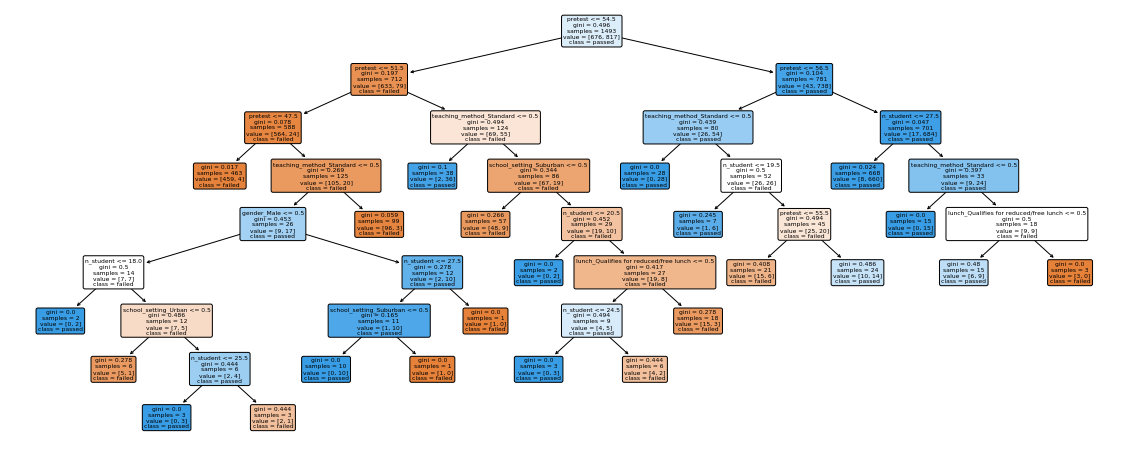

In [29]:
# Using the optimal alpha to build the pruned tree
dt_optimal = DecisionTreeClassifier(ccp_alpha=alpha_optimal)
dt_optimal = dt_optimal.fit(x_train,y_train)

# Plotting the optimally pruned tree
plt.figure(figsize=(20,8))
plot_tree(dt_optimal,feature_names=X_onehot.columns[0:],  
                     class_names=dt_optimal.classes_,filled=True, rounded=True,fontsize=6);

Indeed, the tree is big. Let us check what accuracy it achieves on the test data.

In [30]:
pred_opt = dt_optimal.predict(x_test)
print(classification_report(y_test,pred_opt,digits=4))

              precision    recall  f1-score   support

      failed     0.9485    0.9485    0.9485       291
      passed     0.9570    0.9570    0.9570       349

    accuracy                         0.9531       640
   macro avg     0.9527    0.9527    0.9527       640
weighted avg     0.9531    0.9531    0.9531       640



For comparison, recall the other accuracies: 

In [31]:
from sklearn.metrics import accuracy_score
print('Unrestricted tree:', accuracy_score(y_test,pred))
print('max_depth=3 tree:', accuracy_score(y_test,pred_depth_3))
print('min_impurity_decrease tree:', accuracy_score(y_test,pred_min_imp))
print('Cost complexity pruned tree:' ,accuracy_score(y_test,pred_opt))

Unrestricted tree: 0.9328125
max_depth=3 tree: 0.9453125
min_impurity_decrease tree: 0.9515625
Cost complexity pruned tree: 0.953125


We can see that cost complexity pruning delivers a higher accuracy than the other trees. It delivers a higher accuracy compared to the unrestricted tree, because the unrestricted tree is overfitting the training data. It is also more accurate than both the max_depth=3 tree and the min_impurity_decrease tree for reasons we already discussed.